# Using age, cholestrol, and resting blood pressure to classify heart disease patients from Cleveland #

**John Mao and Caitlyn Chan**


### Introduction ###
Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
Clearly state the question you will try to answer with your project
Identify and describe the dataset that will be used to answer the question
### Preliminary exploratory data analysis ###
Demonstrate that the dataset can be read from the web into R 
Clean and wrangle your data into a tidy format
Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

In [89]:
# importing relevant libraries 
library(tidyverse)
library(tidymodels)
library(repr)
library(dplyr)
install.packages("reshape2") 
library(reshape2)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [52]:

# reading the dataframe from a .csv file
heart_data <- read_csv("heart_data.csv") 

# cleaning and wrangling the data frame, selecting relevant columns
heart_data_clean <- heart_data |>
select(chol, trestbps, age, sex, num) |>
mutate(sex = as_factor(sex))|>
mutate(sex = fct_recode(sex, "male" = "1", "female" = "0")) |>
mutate(num = as_factor(num)) 

# splitting data into training data set and testing data set 
heart_split <- initial_split(heart_data_clean, prop = 0.75, strata = num)

heart_testing <- testing(heart_split)
heart_training <- training(heart_split)

heart_training



Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


chol,trestbps,age,sex,num
<dbl>,<dbl>,<dbl>,<fct>,<fct>
233,145,63,male,0
204,130,41,female,0
236,120,56,male,0
⋮,⋮,⋮,⋮,⋮
205,128,55,female,3
176,164,59,male,3
131,130,57,male,3


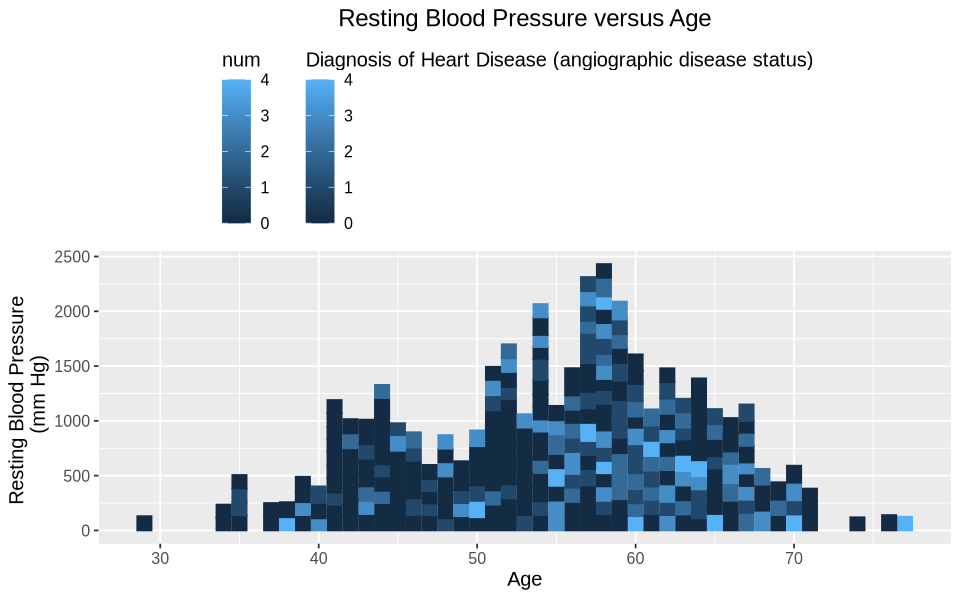

In [57]:
options(repr.plot.width = 8, repr.plot.height = 5)


heart_data_plot_2 <- heart_data |> 
            # should be changing true and false to human readable labels 
            ggplot(aes(x= age, y= trestbps, color = num, fill = num)) +
            geom_bar(stat = "identity")+ 
            labs(x= "Age", y = "Resting Blood Pressure \n (mm Hg)", fill = "Diagnosis of Heart Disease (angiographic disease status)", title = "Resting Blood Pressure versus Age", num = "Diagnosis of Heart Disease")+ # rename false and true 
            theme(text = element_text(size = 12),
            legend.position = "top", 
            legend.direction = "vertical")+
theme(plot.title = element_text(hjust = 0.5))
heart_data_plot_2 
 



### Methods ###
- add all cols given by heart disease data base (original collection)
- how we tided data,
- Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
Describe at least one way that you will visualize the results
### Expected Outcomes and Significance ###
What do you expect to find?
What impact could such findings have?
What future questions could this lead to?
### Bibliography ### 
- proper citation of article, data base, cleavland clinic and people involved? 

Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Using size for a discrete variable is not advised.”


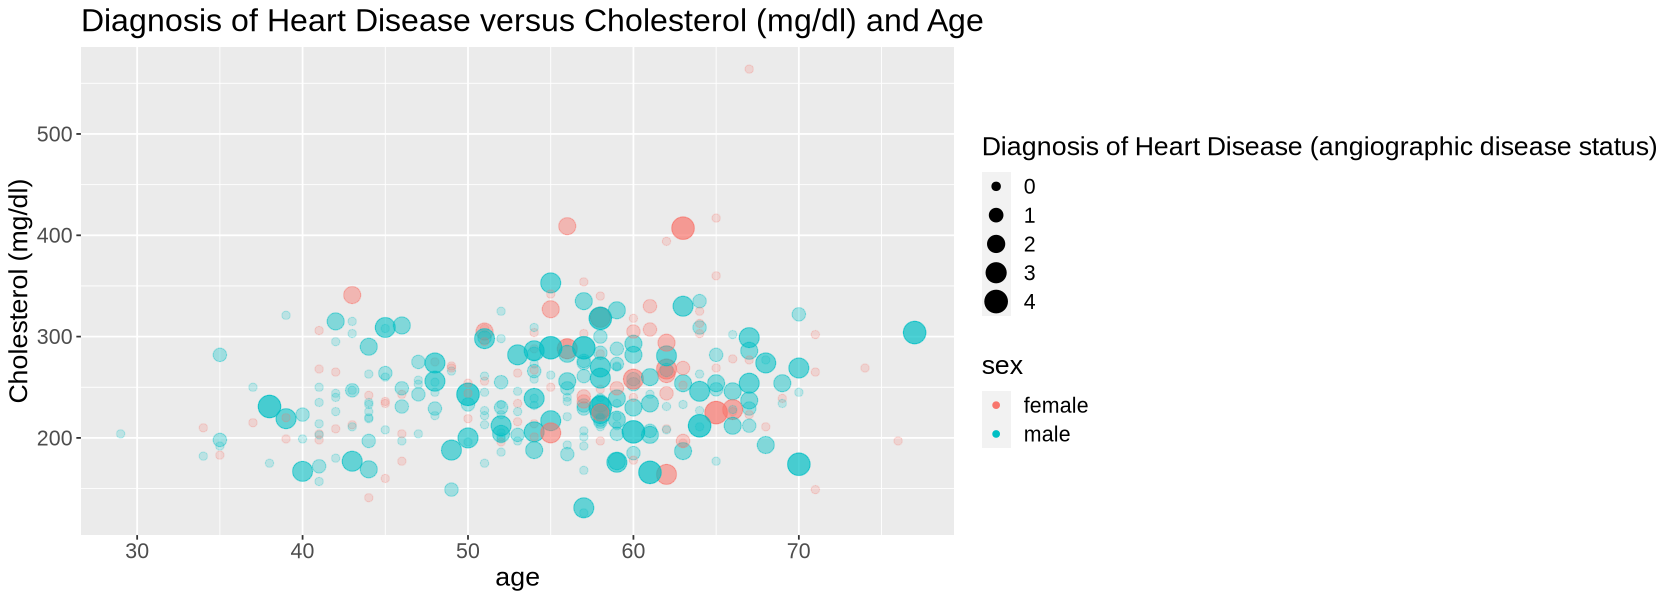

In [94]:
options(repr.plot.width = 14, repr.plot.height = 5)

heart_chol_plot <- ggplot(heart_data, aes(x = age, y = chol, size = num, alpha = num, color = sex)) + 
  geom_point() +
  scale_alpha_discrete(range = c(0.2, 0.7), guide = "none") +
  labs(size = "Diagnosis of Heart Disease (angiographic disease status)",
       title = "Diagnosis of Heart Disease versus Cholesterol (mg/dl) and Age",
       y = "Cholesterol (mg/dl)") +
  theme(text = element_text(size = 16)) 

heart_chol_plot